<a href="https://colab.research.google.com/github/mherbert93/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [x] Choose your target. Which column in your tabular dataset will you predict?
- [x] Is your problem regression or classification?
- [x] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [x] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [x] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [x] Begin to clean and explore your data.
- [x] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [48]:
!pip install category-encoders

In [0]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00397/LasVegasTripAdvisorReviews-Dataset.csv", sep=';')

In [50]:
df.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday


In [51]:
df['Score'].value_counts(normalize=True)

5    0.450397
4    0.325397
3    0.142857
2    0.059524
1    0.021825
Name: Score, dtype: float64

In [52]:
from sklearn.metrics import accuracy_score

majority_class = df['Score'].mode()[0]
y_pred = [majority_class] * len(df['Score'])

print("Baseline accuracy is: ", accuracy_score(df['Score'], y_pred))

Baseline accuracy is:  0.4503968253968254


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df['Score'], random_state=1337)

In [54]:
train['Score'].value_counts()

5    181
4    131
3     58
2     24
1      9
Name: Score, dtype: int64

In [0]:
def wrangle(X):

    X = X.copy()

    def country_aggregation(row): #reduce number of country categories to 4. 'USA', 'Canada', 'UK', and all else 'other'.
        if row['User country'] != "USA" and row['User country'] != 'Canada' and row['User country'] != 'UK':
            return "Other"
        else:
            return row['User country']

    def score_aggregation(row): #due to the very small amount of 1/2 star ratings, we will bin them into 3 groups.
        if row['Score'] == 5:
            return "Excellent"
        elif row['Score'] == 4 or row['Score'] == 3:
            return "Average"
        else:
            return "Bad"

    X['User country'] = X.apply(country_aggregation, axis=1)
    X['Score'] = X.apply(score_aggregation, axis=1)

    return X

In [0]:
train = wrangle(train)
test = wrangle(test)

In [57]:
majority_class = train['Score'].mode()[0]
y_pred = [majority_class] * len(train['Score'])

print("Train baseline accuracy is: ", accuracy_score(train['Score'], y_pred))

Train baseline accuracy is:  0.46898263027295284


In [58]:
majority_class = test['Score'].mode()[0]
y_pred = [majority_class] * len(test['Score'])

print("Test baseline accuracy is: ", accuracy_score(test['Score'], y_pred))

Test baseline accuracy is:  0.46534653465346537


In [0]:
target = 'Score'

train_features = train.drop([target], axis=1)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

categorical_features = train_features.select_dtypes(exclude='number').nunique().index.tolist()


features = numeric_features + categorical_features

In [0]:
y_train = train[target]
X_train = train[features]
X_test = test[features]
y_test = test[target]

In [61]:
X_train.shape

(403, 19)

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBClassifier

#To enable hyperparamter tuning, change tune to True.
#If tune is set to true, we perform hyperparamater tuning on all models marked below as true.
#If tune is set to false, we run the pipelines below that have parameters entered already(best params from previous tuning).
tune = False
forest = True
logistic = True
xgboost = True

forest_distributions = {
    'model__n_estimators': range(250, 500, 50),
    'model__max_depth': range(3, 14),
    'model__max_features': range(2, 14),
    'model__min_samples_leaf': range(2, 4)
}
logistic_distributions = {
    'kbest__k': range(1, 14),
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

xgboost_distributions = {
    'model__n_estimators': [75, 100, 125, 150, 175],
    'model__max_depth': [6, 7, 8, 9, 10, 11, 12, 13],
    'model__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.12, 0.14, 0.16],
    'model__min_child_leaf':[1, 2, 3],
    'model__min_child_weight': [1, 2, 3, 4],
    'model__colsample_bytree':[0.2, 0.3, 0.4, 0.50, 0.60, 0.70],
    'model__subsample':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'model__gamma':[0],
    'model__scale_pos_weight': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                                75, 80, 85, 90, 95, 100]
 }

if tune:

    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('model', RandomForestClassifier(random_state=1337))])

    logistic_pipeline = Pipeline([('encoder', ce.OneHotEncoder()),
                                ('scaler', StandardScaler()),
                                ('kbest', SelectKBest()),
                                ('model', LogisticRegression(random_state=1337))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('model', XGBClassifier(seed=1337))])

    forest_search = GridSearchCV(
        forest_pipeline,
        param_grid=forest_distributions,
        cv=3,
        scoring='neg_log_loss',
        verbose=10,
        n_jobs=15
    )
    logistic_search = GridSearchCV(
        logistic_pipeline,
        param_grid=logistic_distributions,
        cv=3,
        scoring='neg_log_loss',
        verbose=10,
        n_jobs=15
    )
    xgboost_search = RandomizedSearchCV(
        estimator=xgboost_pipeline,
        param_distributions=xgboost_distributions,
        n_iter=10000,
        cv=3,
        scoring='neg_log_loss',
        verbose=10,
        random_state=1337,
        n_jobs=15
    )

    if forest:
        forest_search.fit(X_train, y_train)
        forest_train_pred = forest_search.predict(X_train)
        forest_test_pred = forest_search.predict(X_test)

    if logistic:
        logistic_search.fit(X_train, y_train)
        logistic_train_pred = logistic_search.predict(X_train)
        logistic_test_pred = logistic_search.predict(X_test)

    if xgboost:
        xgboost_search.fit(X_train, y_train)
        xgboost_train_pred = xgboost_search.predict(X_train)
        xgboost_test_pred = xgboost_search.predict(X_test)

else:
    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                            ('model', RandomForestClassifier(random_state=1337,
                                                        max_depth=3,
                                                        max_features=13,
                                                        min_samples_leaf=2,
                                                        n_estimators=400))])
    logistic_pipeline = Pipeline([('encoder', ce.OneHotEncoder()),
                                ('scaler', StandardScaler()),
                                ('kbest', SelectKBest(k=9)),
                                ('model', LogisticRegression(random_state=1337, C=0.01))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                ('model', XGBClassifier(random_state=1337, n_estimators=75, min_child_weight=3,
                                                min_child_leaf=2, max_depth=8, learning_rate=0.05,
                                                gamma=0, subsample=0.5, colsample_bytree=0.3, scale_pos_weight=100))])

    forest_pipeline.fit(X_train, y_train)
    forest_train_pred = forest_pipeline.predict(X_train)
    forest_test_pred = forest_pipeline.predict(X_test)

    logistic_pipeline.fit(X_train, y_train)
    logistic_train_pred = logistic_pipeline.predict(X_train)
    logistic_test_pred = logistic_pipeline.predict(X_test)

    xgboost_pipeline.fit(X_train, y_train)
    xgboost_train_pred = xgboost_pipeline.predict(X_train)
    xgboost_test_pred = xgboost_pipeline.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
if tune:
    target_names = ['Average', 'Bad', 'Excellent']

    if forest:
        print(forest_search.best_params_, '\n')
        print("Best Random Forest CV score: ", forest_search.best_score_, '\n')
        print(classification_report(y_test, forest_test_pred, target_names=target_names), '\n')

        print('\n')

    if logistic:
        print(logistic_search.best_params_, '\n')
        print("Best logistic regression CV score: ", logistic_search.best_score_, '\n')
        print(classification_report(y_test, logistic_test_pred, target_names=target_names), '\n')

        print('\n')

    if xgboost:
        print(xgboost_search.best_params_, '\n')
        print("Best xgboost CV score: ", xgboost_search.best_score_, '\n')
        print(classification_report(y_test, xgboost_test_pred, target_names=target_names), '\n')
else:
    target_names = ['Average', 'Bad', 'Excellent']
    print("Random forest test accuracy score:", accuracy_score(y_test, forest_test_pred), '\n')
    print(classification_report(y_test, forest_test_pred, target_names=target_names))

    print('\n')

    print("Logistic regression test accuracy score:", accuracy_score(y_test, logistic_test_pred), '\n')
    print(classification_report(y_test, logistic_test_pred, target_names=target_names))

    print('\n')

    print("Xgboost test accuracy score:", accuracy_score(y_test, xgboost_test_pred), '\n')
    print(classification_report(y_test, xgboost_test_pred, target_names=target_names))

Random forest test accuracy score: 0.5247524752475248 

              precision    recall  f1-score   support

     Average       0.54      0.53      0.54        47
         Bad       0.00      0.00      0.00         8
   Excellent       0.51      0.61      0.55        46

    accuracy                           0.52       101
   macro avg       0.35      0.38      0.36       101
weighted avg       0.48      0.52      0.50       101



Logistic regression test accuracy score: 0.5643564356435643 

              precision    recall  f1-score   support

     Average       0.58      0.53      0.56        47
         Bad       0.00      0.00      0.00         8
   Excellent       0.55      0.70      0.62        46

    accuracy                           0.56       101
   macro avg       0.38      0.41      0.39       101
weighted avg       0.52      0.56      0.54       101



Xgboost test accuracy score: 0.5445544554455446 

              precision    recall  f1-score   support

     Averag

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Feature importances(only plotting random forrest currently)

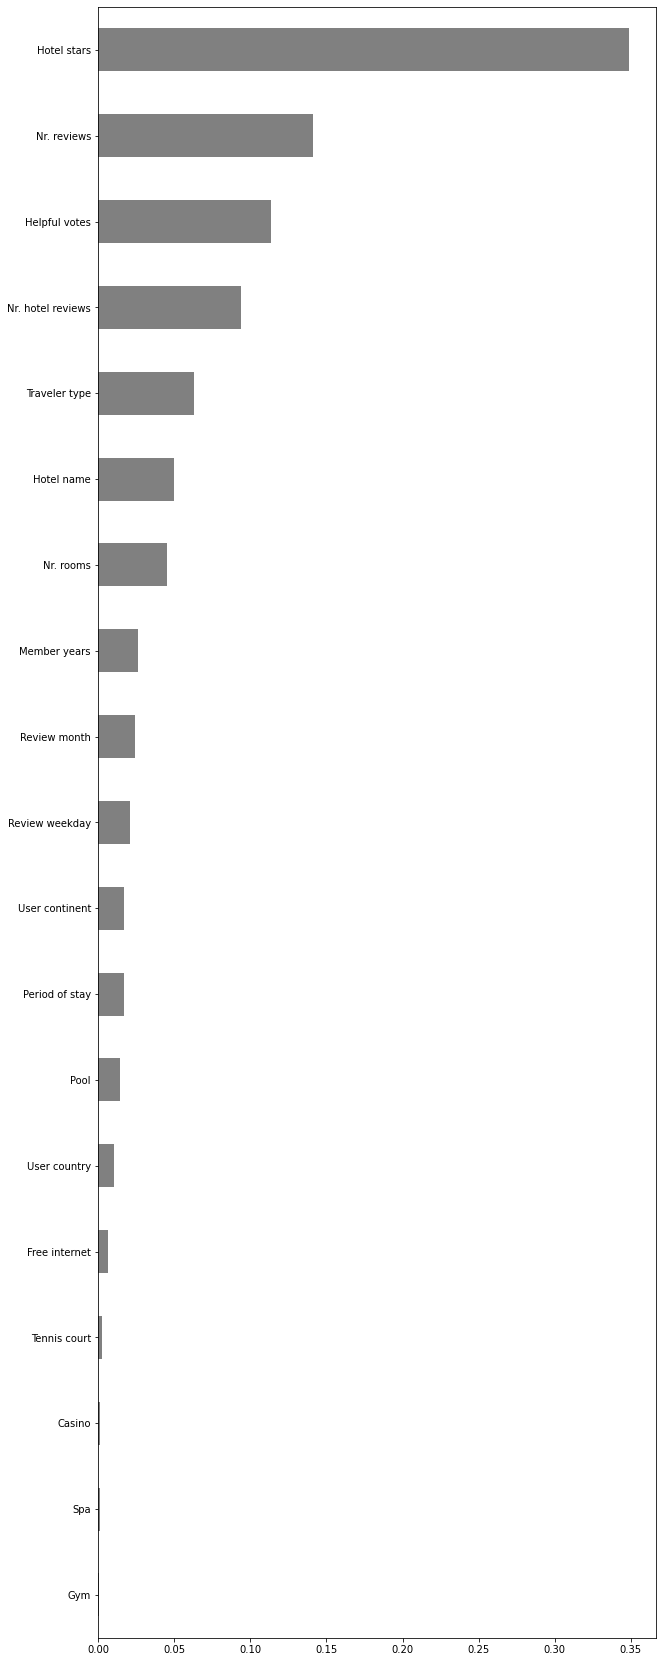

In [64]:
import matplotlib.pyplot as plt

if tune:
    model = forest_search.best_estimator_.named_steps.model
    encoder = forest_search.best_estimator_.named_steps.encoder
else:
    model = forest_pipeline.named_steps.model
    encoder = forest_pipeline.named_steps.encoder


encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

# Exploratory data analysis below

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


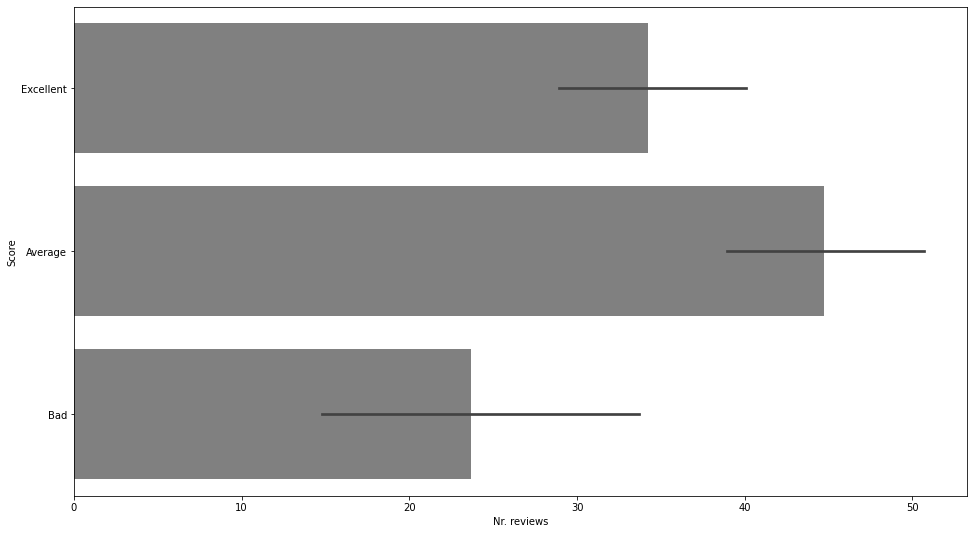

In [65]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[train['Nr. reviews'] < 200]['Nr. reviews'],
    y=train['Score'],
    color='grey'
);


In [66]:
train[train['Nr. reviews'] == 1]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
344,Other,1,0,3,Bad,Mar-May,Families,YES,YES,YES,YES,YES,YES,Tuscany Las Vegas Suites & Casino,3,716,Asia,0,May,Thursday
236,Other,1,0,1,Bad,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,Trump International Hotel Las Vegas,5,1282,Europe,0,November,Wednesday
69,Other,1,0,2,Bad,Sep-Nov,Business,YES,YES,NO,YES,YES,NO,Monte Carlo Resort&Casino,4,3003,Asia,0,November,Wednesday


In [67]:
test[test['Nr. reviews'] == 1]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
411,Other,1,0,2,Excellent,Dec-Feb,Couples,YES,YES,NO,YES,YES,YES,The Venetian Las Vegas Hotel,5,4027,North America,0,February,Sunday
223,USA,1,0,1,Excellent,Mar-May,Couples,YES,YES,NO,YES,YES,YES,Trump International Hotel Las Vegas,5,1282,North America,0,April,Wednesday
219,USA,1,0,2,Excellent,Dec-Feb,Families,YES,YES,NO,YES,YES,YES,Trump International Hotel Las Vegas,5,1282,North America,0,February,Tuesday


In [68]:
train[train['Nr. hotel reviews'] == 1]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
369,Canada,2,1,1,Average,Mar-May,Families,YES,YES,NO,NO,NO,YES,Hilton Grand Vacations at the Flamingo,3,315,North America,3,May,Tuesday
7,USA,2,1,4,Average,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,0,April,Tuesday


In [69]:
train[train['Helpful votes'] == 0]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
104,Other,8,4,0,Average,Mar-May,Couples,YES,YES,YES,YES,YES,YES,Tropicana Las Vegas - A Double Tree by Hilton ...,4,1467,Oceania,1,May,Tuesday
243,USA,4,4,0,Excellent,Dec-Feb,Couples,YES,NO,NO,NO,YES,YES,The Cromwell,"4,5",188,North America,2,February,Monday
14,UK,3,3,0,Average,Jun-Aug,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,1,August,Sunday
157,Other,3,3,0,Average,Jun-Aug,Friends,YES,YES,NO,YES,YES,YES,The Cosmopolitan Las Vegas,5,2959,Oceania,7,July,Tuesday


In [70]:
train[train['Score'] == 'Bad']



,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
10,USA,102,24,58,Bad,Jun-Aug,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,June,Friday
154,Other,24,24,24,Bad,Jun-Aug,Couples,YES,YES,NO,YES,YES,YES,The Cosmopolitan Las Vegas,5,2959,Europe,7,June,Wednesday
70,Other,21,18,6,Bad,Dec-Feb,Business,YES,YES,NO,YES,YES,NO,Monte Carlo Resort&Casino,4,3003,Europe,0,December,Sunday
39,USA,24,6,9,Bad,Jun-Aug,Families,YES,YES,NO,YES,YES,YES,Excalibur Hotel & Casino,3,3981,North America,2,August,Wednesday
67,USA,13,3,3,Bad,Sep-Nov,Couples,YES,YES,NO,YES,YES,NO,Monte Carlo Resort&Casino,4,3003,North America,1,October,Sunday
208,Canada,12,7,11,Bad,Sep-Nov,Business,YES,YES,YES,YES,YES,YES,Wynn Las Vegas,5,2700,North America,4,September,Monday
344,Other,1,0,3,Bad,Mar-May,Families,YES,YES,YES,YES,YES,YES,Tuscany Las Vegas Suites & Casino,3,716,Asia,0,May,Thursday
289,USA,50,39,48,Bad,Dec-Feb,Families,YES,YES,NO,YES,YES,YES,Hilton Grand Vacations on the Boulevard,"3,5",1228,North America,10,January,Thursday
455,Other,20,18,19,Bad,Dec-Feb,Families,YES,YES,NO,YES,YES,YES,Bellagio Las Vegas,5,3933,Asia,4,December,Friday
115,USA,5,3,11,Bad,Sep-Nov,Friends,YES,YES,YES,YES,YES,YES,Tropicana Las Vegas - A Double Tree by Hilton ...,4,1467,North America,1,October,Thursday


In [71]:
test[test['Score'] == 'Bad']



,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
439,Other,3,0,8,Bad,Mar-May,Families,YES,YES,NO,YES,YES,YES,Bellagio Las Vegas,5,3933,Europe,3,April,Tuesday
253,USA,4,0,16,Bad,Jun-Aug,Friends,YES,NO,NO,NO,YES,YES,The Cromwell,"4,5",188,North America,0,July,Thursday
12,USA,7,6,9,Bad,Jun-Aug,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,1,July,Wednesday
55,Other,54,18,16,Bad,Mar-May,Business,YES,YES,NO,YES,YES,NO,Monte Carlo Resort&Casino,4,3003,Africa,5,April,Tuesday
437,USA,30,9,17,Bad,Mar-May,Business,YES,YES,NO,YES,YES,YES,Bellagio Las Vegas,5,3933,North America,0,March,Tuesday
233,Other,2,0,15,Bad,Sep-Nov,Families,YES,YES,NO,YES,YES,YES,Trump International Hotel Las Vegas,5,1282,Africa,1,September,Monday
363,USA,3,3,8,Bad,Dec-Feb,Families,YES,YES,NO,NO,NO,YES,Hilton Grand Vacations at the Flamingo,3,315,North America,1,February,Saturday
458,USA,4,4,2,Bad,Dec-Feb,Couples,YES,YES,NO,YES,YES,YES,Paris Las Vegas,4,2916,North America,1,February,Wednesday
